# Kendrick Mass Filter 
 __Authors:__ Ricardo R. da Silva (ridasilva@ucsd.edu), Madeleine Ernst (mernst@ucsd.edu), Alan K. Jarmusch (ajarmusch@ucsd.edu) <br>
 __Verion:__ 1.0 (Prior to Submission of Manuscript) <br>
 __Date of Last Revision:__ 06-21-2018 <br>
 
**Description**: Kendrick mass is the mass-to-charge (*m/z*) of each ion rescaled to an integer value of a given unit repeat. The defect between the Kendrick scaled *m/z* and the integer Kendrick mass value, i.e. Kendrick mass defect (KMD), is similar between homologous compounds. The Kendrick Mass Filter (MDF) is used to perform selection and removal of data centered around a user-defined KMD, with addtional restrictions on the elution time and presence of possibly multiple homologous compounds eluting together. This notebook calculates and visualizes data output obtained through the Kendrick Mass Filter for a selected dataset using user-defined parameters.

**Input**: <br>
<ul>
<li>**Feature table**: (.csv) file with MS features in columns and samples in rows. Feature IDs are provided in the column names in the following format: "mz;RT". The first column must contain sample names. </li>
</ul> <br>
**Output**: <br>
<ul>
<li>**Summary tables**: (.csv) files containing Kendrick mass filtered output data. </li>
<li>**Plots** (.pdf): Kendrick mass plot, MS1 features plot and spectra before and after applying KMF.</li>
</ul> <br> 
**Dependencies**: R version 3.4.2 (2017-09-28) and packages: tidyr_0.8.0, dplyr_0.7.4, gridExtra_2.3, gtable_0.2.0, Rgraphviz_2.22.0, graph_1.56.0, BiocGenerics_0.24.0, Hmisc_4.0-3, ggplot2_2.2.1, Formula_1.2-2, survival_2.41-3, lattice_0.20-35 

load libraries

In [2]:
library(Hmisc)
library(Rgraphviz)
library(graph)
library(ggplot2)
library(gtable)
library(grid)
library(gridExtra)
library(dplyr)
library(tidyr)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pma

load Kendrick Mass Filter source function

In [3]:
source("kendrick.mass.filter_new_all_datamatrix_terminologyupdate.R")

# Data Input and Preparation for Kendrick Mass Filter

load data matrix (samples in rows and variables in columns)

In [4]:
data_matrix <- read.csv("all17K/tab17PEG.csv", header=T, check.names=F)
head(data_matrix)

SAMPLE,432.281884626908;2.53300454545454,476.305215199788;2.6522125,388.253383000691;2.37624166666666,520.333179050021;2.75036574074074,415.252231763756;2.53302173913043,344.228422164916;2.14777916666666,371.22840590704;2.37920158730158,459.281274159749;2.65194375,503.303718898607;2.75060072463768,⋯,402.770065307617;3.13023333333333,202.109008789062;10.37515,123.091598510742;10.1250166666666,391.201583862304;2.37786666666666,153.137969970703;8.26475,667.394714355468;2.99201666666666,407.222579956054;2.68493333333333,724.43359375;3.28585,219.17446899414;5.62343333333333,130.966156005859;1.47876666666666
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20170728_MS1_17k_PEG_1,6429624506,5408429283,7514160792,4055533016,3666656651,8277896112,3977181472,2950759341,1904767377,⋯,2223329,7827148,50427613,810762,53314268,1399198,1189306,1661110,1181526,28890918
20170728_MS1_17k_PEG_2,6617665352,5505775209,7571515869,4112716607,3882034452,8206703134,0,2955649147,1960552584,⋯,0,0,0,0,0,0,0,0,0,0
20170728_MS1_17k_PEG_3,6576928427,5625211740,7567208669,4159129490,3816859834,8316890279,4083276215,3003420137,1917175859,⋯,0,0,0,0,0,0,0,0,0,0


Prepare data for Kendrick Mass Filter: create a matrix containing one column with *m/z* values and another column with RT values

In [5]:
vec <- do.call(rbind,lapply(strsplit(colnames(data_matrix)[2:ncol(data_matrix)],";"),matrix,ncol=2,byrow=TRUE))
class(vec) <- "numeric"
colnames(vec)<- c("mz","rt")
head(vec)

mz,rt
432.2819,2.533005
476.3052,2.652213
388.2534,2.376242
520.3332,2.750366
415.2522,2.533022
344.2284,2.147779


# Apply Kendrick Mass Filter to data
Parameters, which can be specified when running the mass filter: <br>
1. __Kendrick mass defect (KMD) [Da]__ - tolerance of mass defect. Smaller values result in a more stingent homology parameter. <br>
2. __Retention time (RT) [min]__ - tolerance for chromatographic elution. <br>
3. __Number of Observations (NOS)__ - how many oligomer peaks must be observed. Larger values result in more specificity. 
4. __connection_filter__ must be set to "TRUE" for NOS parameter to function correctly. <br>
5. __polymer__ - selection of polymers or signals to filter, options are:<br>
alkane_other_CH2, oxidation, water_cluster, alkane_C2H4, methanol_cluster, acetonitrile_cluster, propylation_other_C3H6, polyethylene_glycol_other_C2H4O1, perfluoro_CF2, ammoniumchloride_cluster, butylation_other_C4H8, sodiumchloride_cluster, polypropylene_glycol_other_C3H6O1, ammoniumformate_cluster, sodiumformate_cluster, potassiumchloride_cluster, polysiloxane, <br> sodiumacetate_cluster

run the Kendrick Mass Filter with user-specified parameters

In [6]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polyethylene_glycol_other_C2H4O1", 
    KMD = 0.01, 
    RT = 0.8, 
    NOS = 2, 
    connection_filter = TRUE)

show output table

In [7]:
output$Kendrickfiltered_MS1features_wgraph

SAMPLE,394.213268280029;2.38114166666666,522.332708185369;2.75181363636363,434.284787691556;2.53569871794871,349.226055908203;3.03508666666666,346.230796813964;2.15283888888888,362.722486707899;3.09536111111111,439.238014221191;2.53009375,242.284182341202;5.29321594202898,351.702832539876;3.03940833333333,⋯,393.1240234375;2.36386666666666,402.770065307617;3.13023333333333,202.109008789062;10.37515,123.091598510742;10.1250166666666,391.201583862304;2.37786666666666,153.137969970703;8.26475,667.394714355468;2.99201666666666,407.222579956054;2.68493333333333,219.17446899414;5.62343333333333,130.966156005859;1.47876666666666
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20170728_MS1_17k_PEG_1,389419229,208552138,267331831,110655205,229265525,48109151,69257665,77122861,32664250,⋯,13141799,2223329,7827148,50427613,810762,53314268,1399198,1189306,1181526,28890918
20170728_MS1_17k_PEG_2,400710384,208948912,275215870,112018694,228195434,50538336,73139530,63206180,32331562,⋯,0,0,0,0,0,0,0,0,0,0
20170728_MS1_17k_PEG_3,396988066,207781090,270685029,110163424,229524596,46201803,72711907,78138815,32165318,⋯,0,0,0,0,0,0,0,0,0,0


# Kendrick Mass Plot

create Kendrick mass plot

In [8]:
kendrickmassfilterinfo <- as.data.frame(output$kendrickmassfilterinfo_original)
kendrickmassfilterinfo_filtered_wgraph <- as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph)
kendrickmassfilterinfo_diff <- kendrickmassfilterinfo[((kendrickmassfilterinfo[,1] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,1]) & 
                                                       (kendrickmassfilterinfo[,2] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,2])) != TRUE,]

Original MS1 features are displayed in black, and filtered MS1 features in red. Homologous compounds (polymers) can be readily identified by plotting the integer Kendrick values versus the Kendrick mass defect, resulting in a horizontal alignment in the Kendrick mass plot. 

Saving 7 x 7 in image


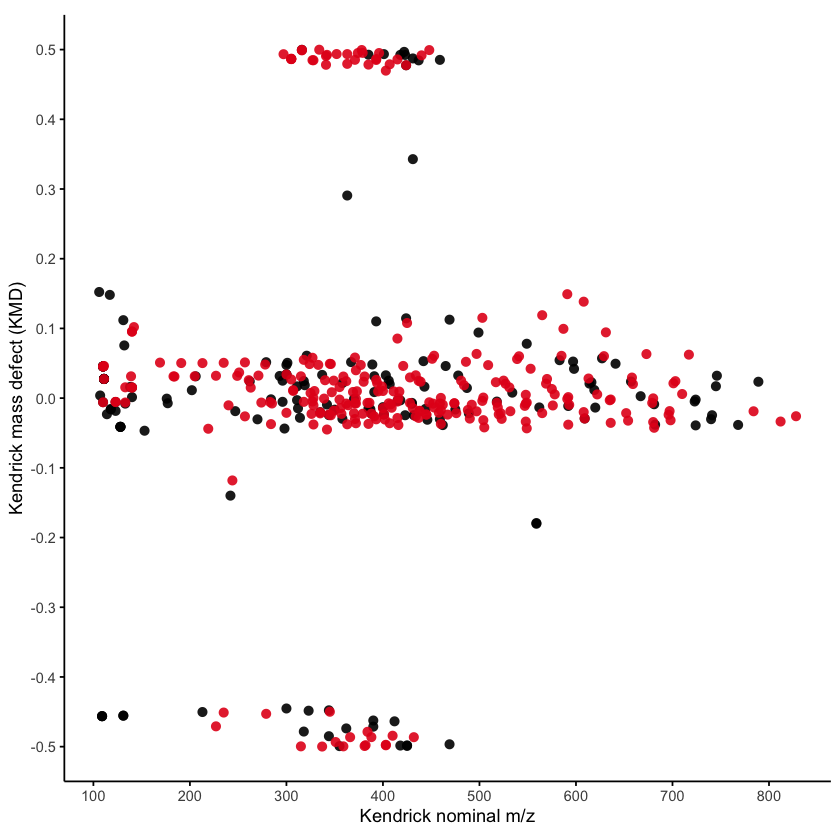

In [9]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=2.5, alpha=0.9, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=2.5, alpha=0.9,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Kendrickplot)
ggsave("Kendrickmassplot.pdf")

Following Fouquet and Sato (Anal. Chem. 2017, 89, 2682−2686) definitions of KM as


\begin{equation}
KM(ion) = m/z(ion) * \frac{round(m(base\ unit))}{m(base\ unit)}
\end{equation}

NKM as

\begin{equation}
NKM(ion) = round(KM(ion)) 
\end{equation}

and KMD as

\begin{equation}
KMD(ion) = NKM(ion) - KM(ion)
\end{equation}

and CNKM as

\begin{equation}
CNKM(ion) = NKM(ion) - celling(NKM(ion)-m/z(ion))
\end{equation}

The expansion of the KMD dimension is accomplished using a fractional base unit 

\begin{equation}
base\ unit = \frac{(base\ unit)}{X}
\end{equation}

In [6]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polyethylene_glycol_other_C2H4O1", 
    # Re-scale according to fraction base, for this case
    # ~ fractionBase*mass_defect_parameter*2
    KMD = 0.95,
    RT = 0.8, 
    NOS = 2, 
    connection_filter = TRUE,
    fractionBase=43)

In [7]:
kendrickmassfilterinfo <- as.data.frame(output$kendrickmassfilterinfo_original)
kendrickmassfilterinfo_filtered_wgraph <- as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph)
kendrickmassfilterinfo_diff <- kendrickmassfilterinfo[((kendrickmassfilterinfo[,1] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,1]) & 
                                                       (kendrickmassfilterinfo[,2] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,2])) != TRUE,]

Saving 7 x 7 in image


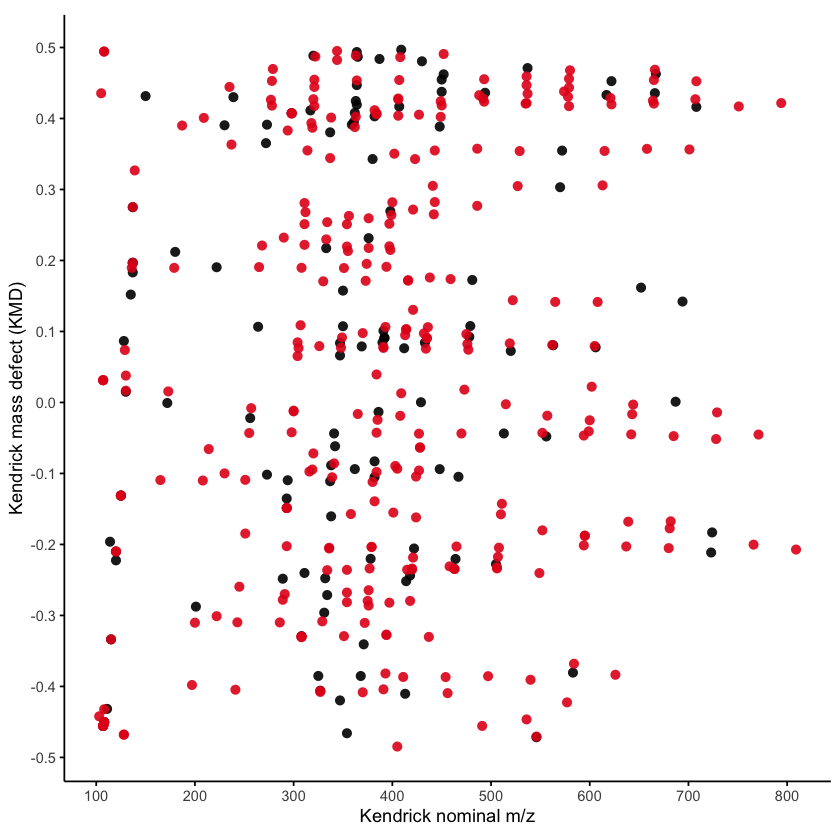

In [8]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=2.5, alpha=0.9, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=2.5, alpha=0.9,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Kendrickplot)
ggsave("Kendrickmassplot.pdf")

# MS1 Feature Plot

create MS1 feature plot

In [10]:
#colnames(output$Kendrickfiltered_MS1features_wgraph)
KMF_vec <- do.call(rbind,lapply(strsplit(colnames(output$Kendrickfiltered_MS1features_wgraph)[2:ncol(output$Kendrickfiltered_MS1features_wgraph)],";"),matrix,ncol=2,byrow=TRUE))
class(KMF_vec) <- "numeric"
colnames(KMF_vec)<- c("mz","rt")
head(KMF_vec)

mz,rt
394.2133,2.381142
522.3327,2.751814
434.2848,2.535699
349.2261,3.035087
346.2308,2.152839
362.7225,3.095361


In [11]:
Filtered_matrix_KMF_wgraph_MS1_plot_vec <- as.data.frame(vec[((vec[,1] %in% KMF_vec[,1]) & (vec[,2] %in% KMF_vec[,2])) != TRUE,])

Original MS1 features are displayed in black, and filtered MS1 features in red.

Saving 7 x 7 in image


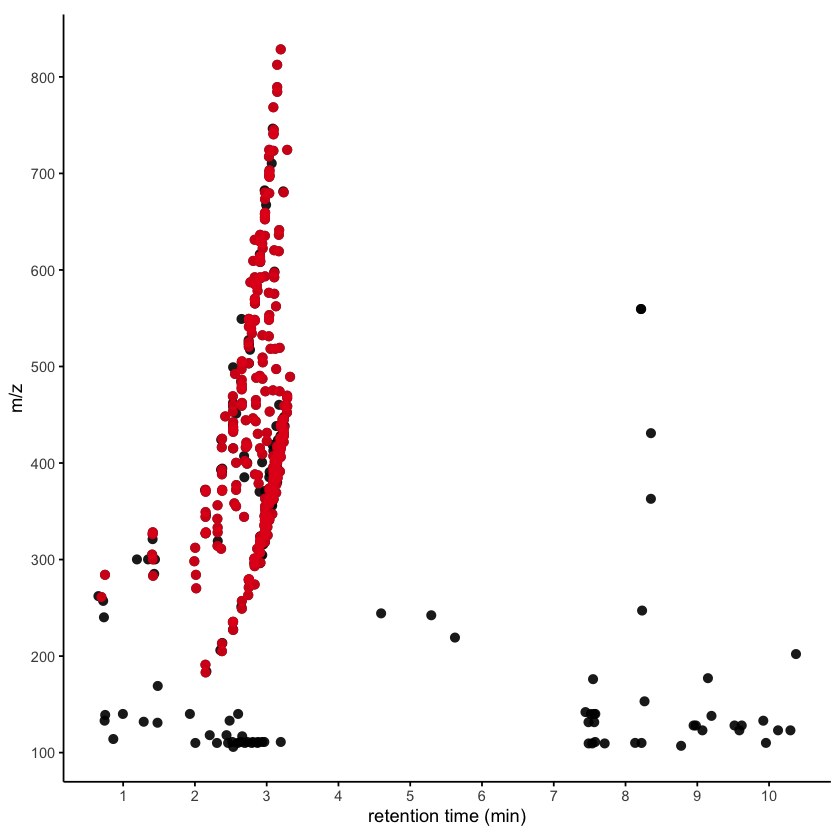

In [12]:
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=2.5, alpha=0.9, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=2.5, alpha=0.9, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(MS1featureplot)
ggsave("MS1featureplot.pdf")

# Plot Spectra

create MS1 feature spectrum prior to KMF

In [13]:
original_spectrum <- as.data.frame(cbind(vec,as.numeric(t(data_matrix)[2:nrow(t(data_matrix)),2])))
label <- format(round(vec[,1], 2), nsmall = 4)
original_spectrum <- cbind(original_spectrum, label)
colnames(original_spectrum) <- c("mz","rt","abundance","mz_label")
head(original_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
432.2819,2.533005,6617665352,432.2800
476.3052,2.652213,5505775209,476.3100
388.2534,2.376242,7571515869,388.2500
520.3332,2.750366,4112716607,520.3300
415.2522,2.533022,3882034452,415.2500
344.2284,2.147779,8206703134,344.2300


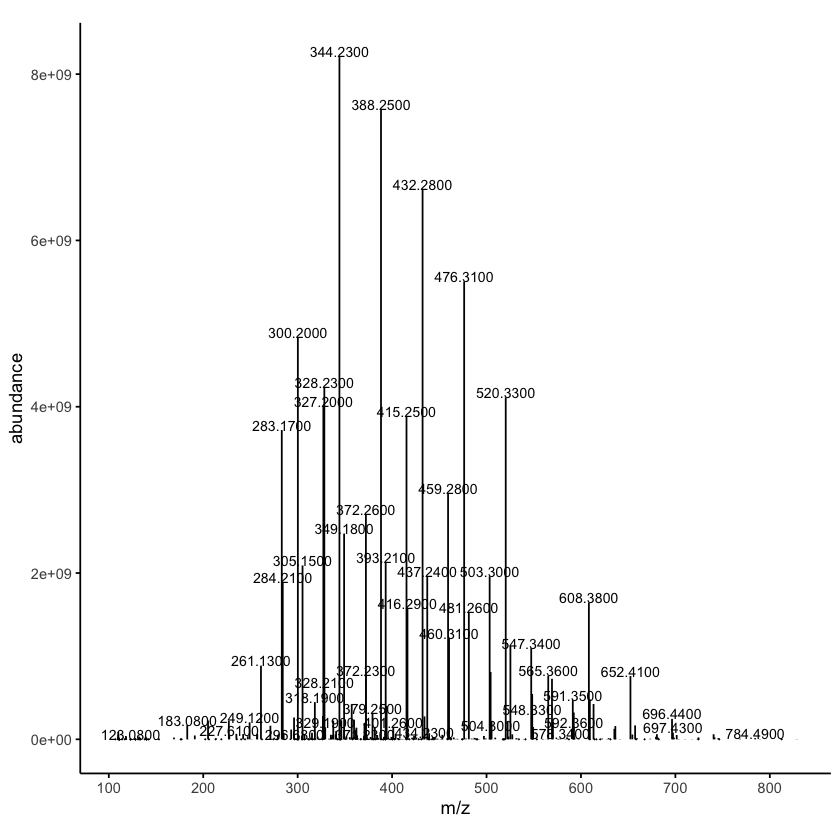

In [14]:
# Original spectrum
Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Original_Spectrum_plot)

create MS1 feature spectrum after KMF

In [15]:
KMF_spectrum <- as.data.frame(cbind(KMF_vec,as.numeric(t(output$Kendrickfiltered_MS1features_wgraph)[2:nrow(t(output$Kendrickfiltered_MS1features_wgraph)),2])))
label <- format(round(KMF_vec[,1], 2), nsmall = 4)
KMF_spectrum <- cbind(KMF_spectrum, label)
colnames(KMF_spectrum) <- c("mz","rt","abundance","mz_label")
head(KMF_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
394.2133,2.381142,400710384,394.2100
522.3327,2.751814,208948912,522.3300
434.2848,2.535699,275215870,434.2800
349.2261,3.035087,112018694,349.2300
346.2308,2.152839,228195434,346.2300
362.7225,3.095361,50538336,362.7200


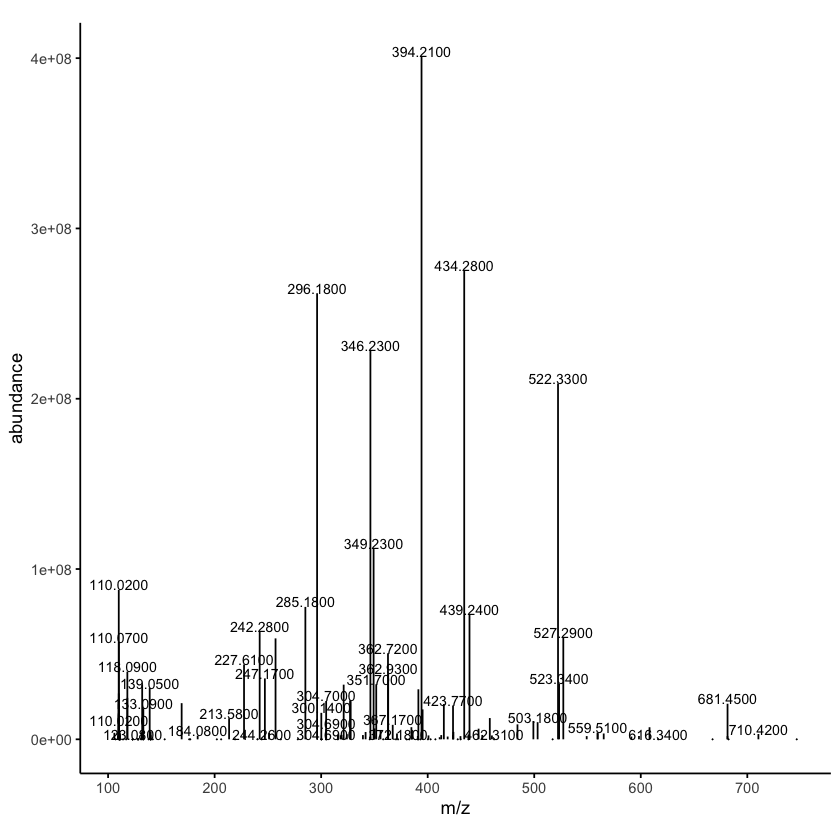

In [16]:
KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_spectrum_plot)

create spectrum of MS1 features removed via KMF

In [17]:
# MS1 Features (calculate MS1 Features that were removed rather than retained)
Filtered_matrix_KMF_wgraph_MS1_plot <- 
   t(data_matrix)[which(((vec[,1] %in% KMF_vec[,1]) & 
                  (vec[,2] %in% KMF_vec[,2])) != TRUE)+1,]

In [18]:
which(((vec[,1] %in% KMF_vec[,1]) & 
                  (vec[,2] %in% KMF_vec[,2])) != TRUE)

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  47  48  49  51  52  54  55  56  57
 [55]  58  59  60  61  62  63  64  65  66  68  69  70  71  72  73  74  75  76
 [73]  77  78  79  81  82  83  84  85  86  87  88  90  91  92  93  94  95  98
 [91]  99 100 101 103 104 106 107 110 111 112 114 115 116 117 119 120 121 124
[109] 125 126 128 130 131 132 133 135 136 137 138 139 140 141 142 143 146 147
[127] 148 149 150 151 152 153 156 157 159 160 161 162 163 164 165 166 167 169
[145] 171 172 173 174 175 176 177 178 181 182 184 186 188 190 191 193 194 196
[163] 197 198 202 203 204 205 207 209 210 211 212 213 215 216 217 220 221 223
[181] 225 227 228 229 230 231 232 233 234 236 237 238 239 242 243 245 247 248
[199] 250 251 252 253 254 256 257 258 259 260 261 262 268 269 270 274 276 280
[217] 282 283 285 286 290 296 297 306 307 314 318 323 324 329 331 333 336 337
[235] 338 339 340 341 343 344 347 348 349 352 353 354 355 356 359 367 370 375
[253] 377 378 379 386 389 392 393 396 398 400 406 407 409 415 419 427

In [19]:
vec[44:50,]

mz,rt
370.7354,3.094469
337.7010,2.975427
394.2133,2.381142
657.3677,2.975519
570.3122,2.835858
329.1859,2.975315
522.3327,2.751814


In [20]:
head(KMF_vec)

mz,rt
394.2133,2.381142
522.3327,2.751814
434.2848,2.535699
349.2261,3.035087
346.2308,2.152839
362.7225,3.095361


In [21]:
Filtered_matrix_KMF_wgraph_MS1_plot[44:50,]

370.7354443868;3.09446944444444,189048621,196923910,187149623
337.700962232506;2.9754268115942,222663410,223682178,218279977
657.367707625679;2.97551884057971,174137216,167303485,164316870
570.312183726917;2.83585757575757,188597572,198128558,195740787
329.185869852701;2.97531481481481,146137144,144655969,141931261
592.364072163899;2.90874444444444,137913756,139155933,143006797
381.726384480794;3.09468124999999,142055838,149175731,133962258


In [22]:
KMF_filtered_features_spectrum <- as.data.frame(cbind(Filtered_matrix_KMF_wgraph_MS1_plot_vec, 
                                                      as.numeric(Filtered_matrix_KMF_wgraph_MS1_plot[,2])))
label <- format(round(Filtered_matrix_KMF_wgraph_MS1_plot_vec[,1], 2), nsmall = 4)
KMF_filtered_features_spectrum <- cbind(KMF_filtered_features_spectrum, label)
colnames(KMF_filtered_features_spectrum) <- c("mz","rt","abundance","mz_label")
KMF_filtered_features_spectrum[44:50,]

,mz,rt,abundance,mz_label
,<dbl>,<dbl>,<dbl>,<fct>
44,370.7354,3.094469,196923910,370.7400
45,337.7010,2.975427,223682178,337.7000
46,657.3677,2.975519,167303485,657.3700
47,570.3122,2.835858,198128558,570.3100
48,329.1859,2.975315,144655969,329.1900
49,592.3641,2.908744,139155933,592.3600
50,381.7264,3.094681,149175731,381.7300


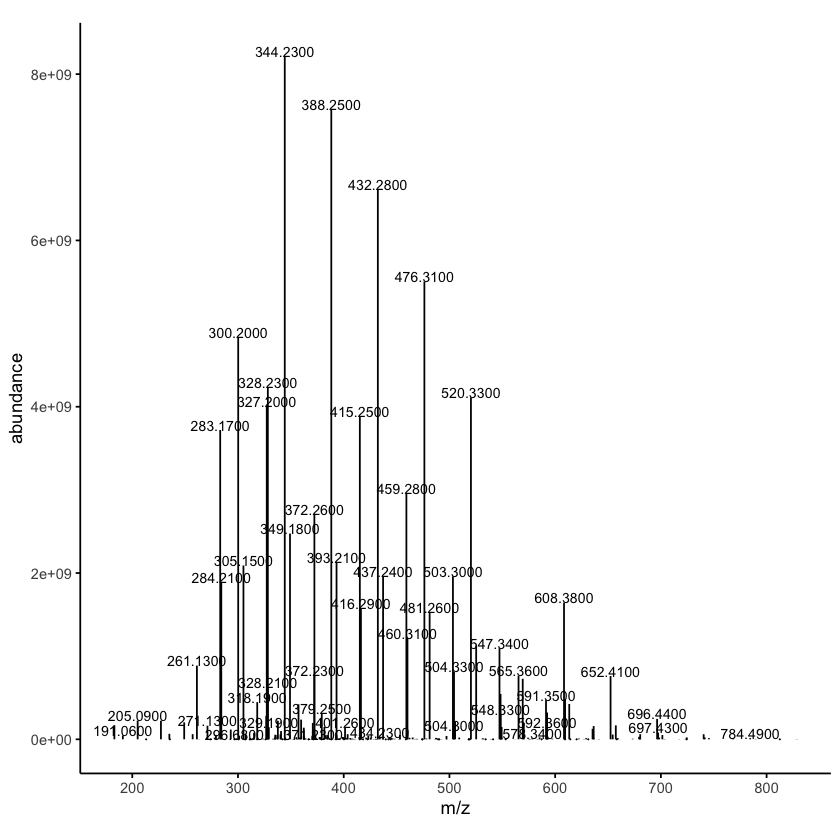

In [23]:
KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_filtered_features_spectrum_plot)

create a) Kendrick mass plot, b) MS1 feature plot, c) MS1 feature spectrum prior and d) after KMF as well as e) MS1 features removed via KMF:

Saving 7.1 x 7 in image


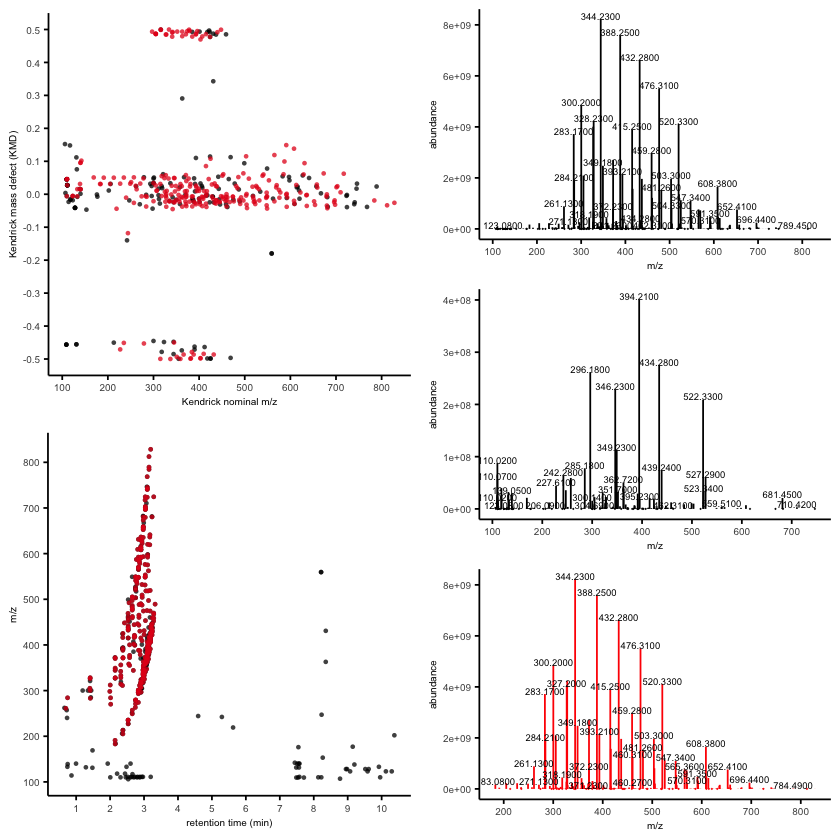

In [24]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=1, alpha=0.75, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=1, alpha=0.75,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
    
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=1, alpha=0.75, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=1, alpha=0.75, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)

Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="red")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6))  

lay <- rbind(c(1,3),
             c(1,3),
             c(1,4),
             c(2,4),
             c(2,5),
             c(2,5))
plot <- grid.arrange(Kendrickplot,MS1featureplot,Original_Spectrum_plot,KMF_spectrum_plot,KMF_filtered_features_spectrum_plot, layout_matrix = lay)

ggsave("20180611_KMF_Figure_PEG400.pdf", plot, scale=1, width=7.1, units="in")

save output tables to files

In [25]:
# write .csv table containing the KMF info matrix
write.csv(kendrickmassfilterinfo_diff, "20160611_PEG_KMF_info.csv", row.names=FALSE)

# write .csv table containing MS1 features remaining after Kendrick mass filtering
write.csv(output$Kendrickfiltered_MS1features_wgraph, "20160611_PEG_KMF_resultingdatamatrix.csv",row.names=FALSE)

# write .csv table of MS1 features removed from the data via the Kendrick mass filter
write.csv(Filtered_matrix_KMF_wgraph_MS1_plot_vec, "20160611_PEG_KMF_featuresfiltered.csv", row.names=FALSE)